# Flower Recognition CNN Keras

## [ Please upvote / star if you like it ;)  ]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## CONTENTS ::

[ **1 ) Importing Various Modules**](#content1)

[ **2 ) Preparing the Data**](#content2)

[ **3 ) Modelling**](#content3)

[ **4 ) Evaluating the Model Performance**](#content4)

[ **5 ) Visualizing Predictons on the Validation Set**](#content5)

<a id="content1"></a>
## 1 ) Importing Various Modules.

In [ ]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image

<a id="content2"></a>
## 2 ) Preparing the Data

## 2.1) Making the functions to get the training and validation set from the Images

In [ ]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR=r'/content/drive/MyDrive/DATASET/flower_images/DAISY'
FLOWER_SUNFLOWER_DIR=r'/content/drive/MyDrive/DATASET/flower_images/Sunflower'
FLOWER_TULIP_DIR=r'/content/drive/MyDrive/DATASET/flower_images/Tulip'
FLOWER_DANDI_DIR=r'/content/drive/MyDrive/DATASET/flower_images/DANDI'
FLOWER_ROSE_DIR=r'/content/drive/MyDrive/DATASET/flower_images/ROSE'


In [ ]:
def assign_label(img,flower_type):
    return flower_type


In [ ]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

        X.append(np.array(img))
        Z.append(str(label))




In [ ]:
make_train_data('Lilly',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|██████████| 1000/1000 [00:43<00:00, 23.21it/s]

1000


In [ ]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|██████████| 1000/1000 [00:08<00:00, 117.98it/s]

2000


In [ ]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|██████████| 1000/1000 [00:25<00:00, 38.60it/s]

3000


In [ ]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

100%|██████████| 1000/1000 [00:55<00:00, 17.86it/s]

5010


In [ ]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|██████████| 1010/1010 [00:49<00:00, 20.28it/s] 

4010


## 2.2 ) Visualizing some Random Images

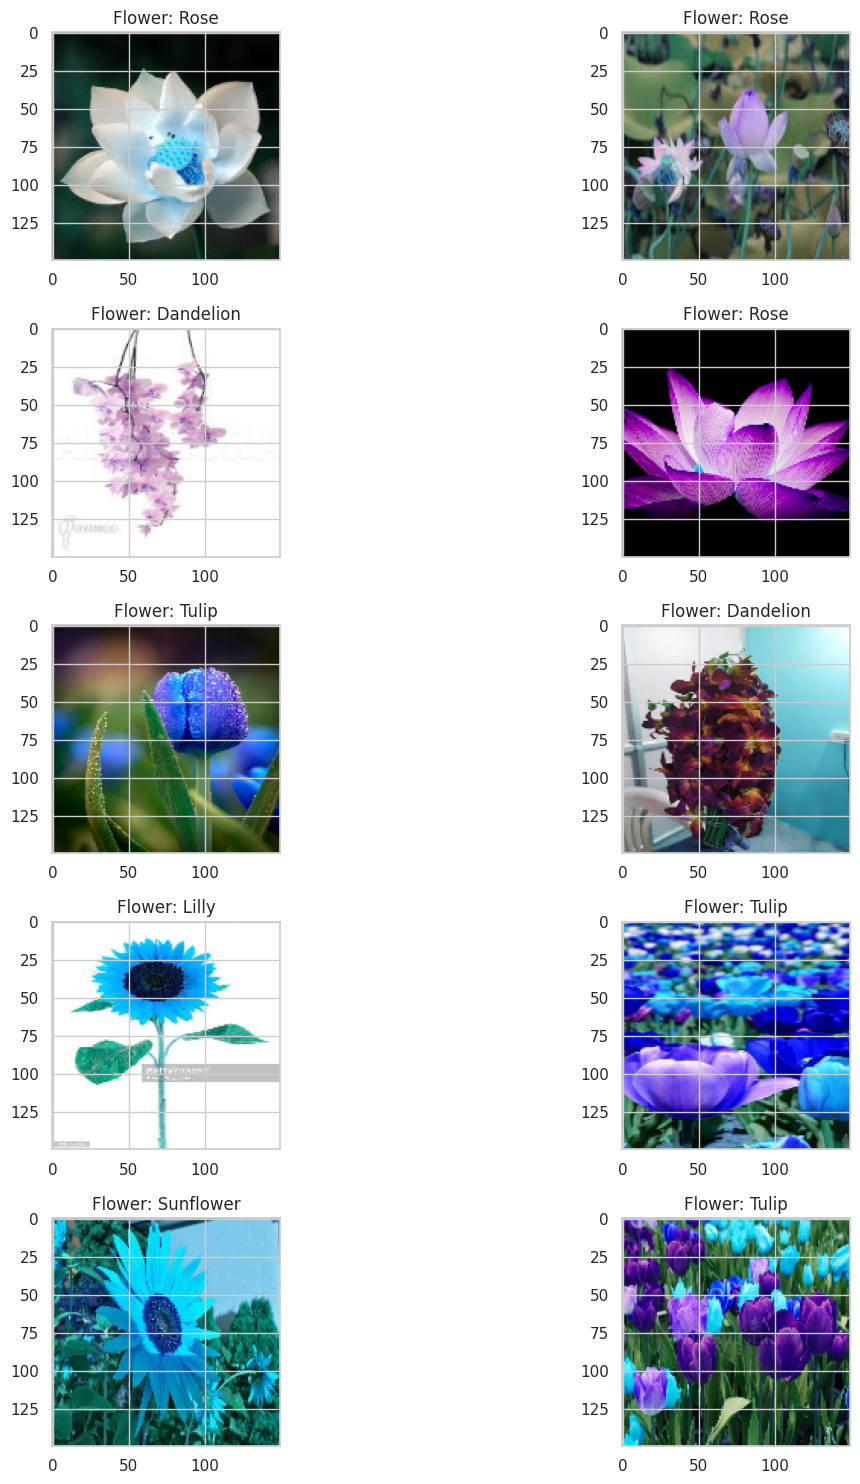

In [ ]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])

plt.tight_layout()


## 2.3 ) Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding

In [ ]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

## 2.4 ) Splitting into Training and Validation Sets

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)


## 2.5 ) Setting the Random Seeds

In [ ]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

<a id="content3"></a>
## 3 ) Modelling

## 3.1 ) Building the ConvNet Model

In [ ]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

## 3.2 ) Using a LR Annealer

In [ ]:
batch_size=128
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

## 3.3 ) Data Augmentation to prevent Overfitting

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

## 3.4 ) Compiling the Keras Model & Summary

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

## 3.5 ) Fitting on the Training set and making predcitons on the Validation set

In [ ]:
History = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 282s 9s/step - accuracy: 0.3133 - loss: 1.5119 - val_accuracy: 0.4485 - val_loss: 1.1470
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 31s 852ms/step - accuracy: 0.4219 - loss: 1.1096 - val_accuracy: 0.4573 - val_loss: 1.1491
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 305s 10s/step - accuracy: 0.4965 - loss: 1.0811 - val_accuracy: 0.5188 - val_loss: 0.9917
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 790ms/step - accuracy: 0.5469 - loss: 0.9971 - val_accuracy: 0.5180 - val_loss: 0.9957
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 333s 9s/step - accuracy: 0.5260 - loss: 0.9683 - val_accuracy: 0.5156 - val_loss: 1.0583
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 31s 776ms/step - accuracy: 0.5156 - loss: 0.9903 - val_accuracy: 0.5315 - val_loss: 1.0451
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 275s 9s/step - accuracy: 0.5408 - loss: 0.9572 - val_accuracy: 0.5204 - val_loss: 0.9555
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 31s 776ms/step - accuracy: 0.5156 - loss: 1.0209 - val_accuracy: 0

<a id="content4"></a>
## 4 ) Evaluating the Model Performance

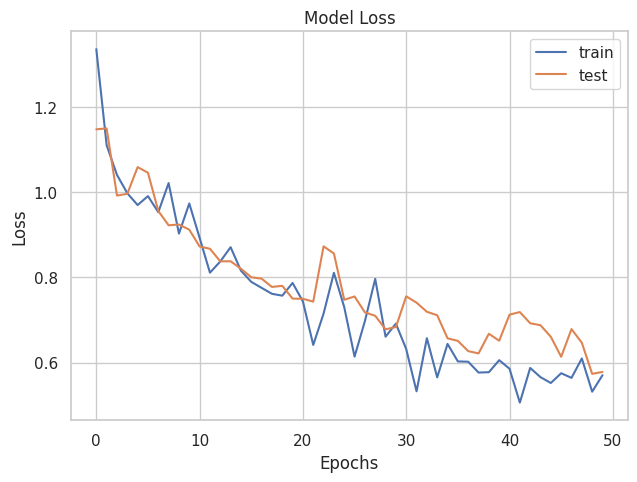

In [ ]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

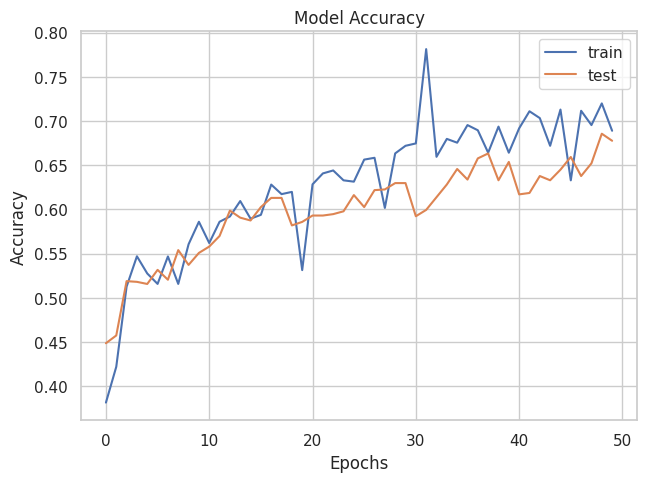

In [ ]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()
